In [123]:
import torch
from torch import nn
import os
import cv2
import matplotlib.pyplot as plt
import  numpy as np

In [124]:
!kaggle datasets download -d stoicstatic/face-recognition-dataset

if not os.path.exists("Extracted Faces"):
    !unzip -q face-recognition-dataset.zip "Extracted Faces/*"

face-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


### Data preprocessing

In [125]:
data_folder = os.path.join("Extracted Faces", "Extracted Faces")

image_data = []
for each_person in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, each_person)
    
    for each_img in os.listdir(folder_path):
        img_path = os.path.join(folder_path,  each_img)
        
        img = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)
        
        image_data.append([img, int(each_person)])

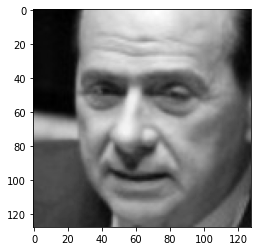

In [126]:
image_data[0][0].shape

dataset_size = 500

diff = 0
same = 0
k = 0
# 63980
train_inputs = torch.empty(dataset_size, 2, 128, 128)
train_labels = torch.empty(dataset_size)

for i in range(len(image_data)):
    for j in range(i + 1, len(image_data)):
        if image_data[i][1] != image_data[j][1]:
            if diff < dataset_size / 2:
                diff += 1
                train_inputs[k] = torch.Tensor(np.array([image_data[i][0], image_data[j][0]]))
                train_labels[k] = 1
                k += 1


        else:
            if same < dataset_size / 2:
                same += 1
                train_inputs[k] = torch.Tensor(np.array([image_data[i][0], image_data[j][0]]))
                train_labels[k] = 0
                k += 1

plt.imshow(train_inputs[-1][0], cmap='gray')
plt.show()


### Model

In [127]:
class SiameseCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding = 5),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 5,  stride = 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 5, stride = 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.AdaptiveAvgPool2d((1, 1)),

            nn.Flatten(),
            nn.Linear(64, 48),

            # nn.Linear(14400, 1024),
            # nn.ReLU(),
            # nn.Linear(1024, 64),
            # nn.ReLU()
        )

    def forward(self, input):
        return self.network(input)

In [128]:
def train(model, lr, n_epochs, train_inputs, train_labels):
    optimizer = torch.optim.SGD(model.parameters(), lr)

    # print(len(data))
    for i in range(n_epochs):
        epoch_loss = 0

        shuffled_idx = torch.randperm(len(train_inputs))
        train_inputs = train_inputs[shuffled_idx]

        train_labels = train_labels[shuffled_idx]
        
        for j in range(len(train_inputs)):
            # print(train_inputs[j][1])
            val1 = model.forward(train_inputs[j][0].unsqueeze(0).unsqueeze(0))
            val2 = model.forward(train_inputs[j][1].unsqueeze(0).unsqueeze(0))
            # print(val1, val2)
            dist = nn.MSELoss()(val1, val2)
            sig_dist = nn.Sigmoid()(dist)*2 - 1
            # print(sig_dist)
            loss = nn.BCELoss()(sig_dist, train_labels[j])
            # print(loss)
            epoch_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # if j%100 == 0:
            #     print(epoch_loss / 500)

        print(epoch_loss/500)

model = SiameseCNN()

train(model, .001, 10, train_inputs, train_labels)

tensor(1.9318, grad_fn=<DivBackward0>)
tensor(0.7187, grad_fn=<DivBackward0>)
tensor(0.2134, grad_fn=<DivBackward0>)
tensor(0.0931, grad_fn=<DivBackward0>)
tensor(0.0595, grad_fn=<DivBackward0>)
tensor(0.0426, grad_fn=<DivBackward0>)
tensor(0.0370, grad_fn=<DivBackward0>)
tensor(0.0307, grad_fn=<DivBackward0>)
tensor(0.0285, grad_fn=<DivBackward0>)
tensor(0.0243, grad_fn=<DivBackward0>)
